In [21]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score

import re

sns.set_theme(style='darkgrid')

cm = px.colors.sequential.Emrld

warnings.filterwarnings('ignore')


<h2> 1. Explotary Data Analysis</h2>


In [22]:
train = pd.read_csv('train.csv')
train_index = train.index
y = train['Survived']

test = pd.read_csv('test.csv')


df = pd.concat([train, test], ignore_index=True)
df['Survived'] = df['Survived'].fillna('NaN')

test_index = df.index[-test.shape[0]:]


In [23]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   object 
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 122.8+ KB


<h4> 1.1 Sex </h4>


<AxesSubplot: xlabel='Sex', ylabel='Count'>

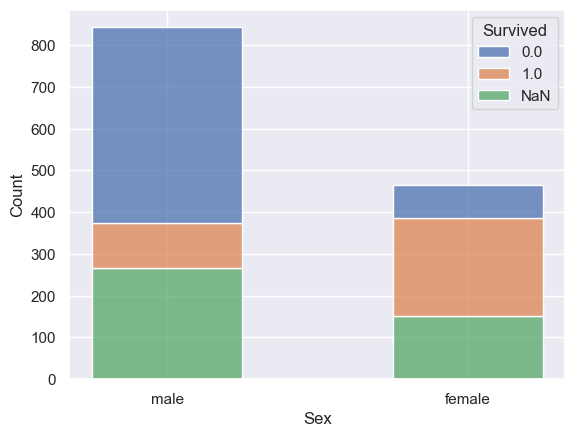

In [24]:
sns.histplot(data=df, x='Sex', hue='Survived', multiple='stack', shrink=0.5)


As we can see, the per cent of survived women is much higher than men. This feature looks informative.


<h4> 1.2 Pclass </h4>


<AxesSubplot: xlabel='Pclass', ylabel='Count'>

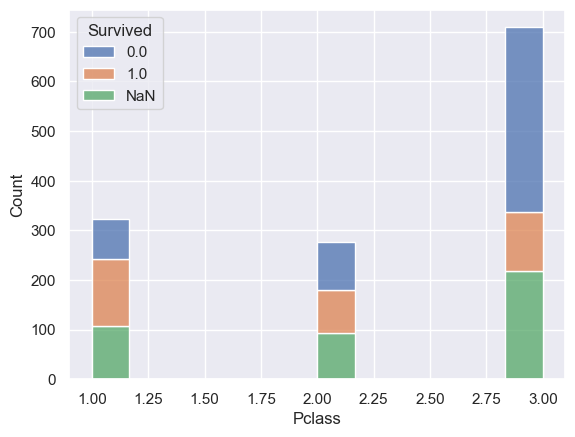

In [25]:
sns.histplot(data=df, x='Pclass', hue='Survived', multiple='stack', shrink=1)


The number of survivors in the 3rd class is significantly low. Probably, it is connected with the location of these people in the moment of accident. I can assume that the lower class means the lower deck.

Overall, this feature is informative.


<h4> 1.3 Age </h4>


<AxesSubplot: xlabel='Age', ylabel='Count'>

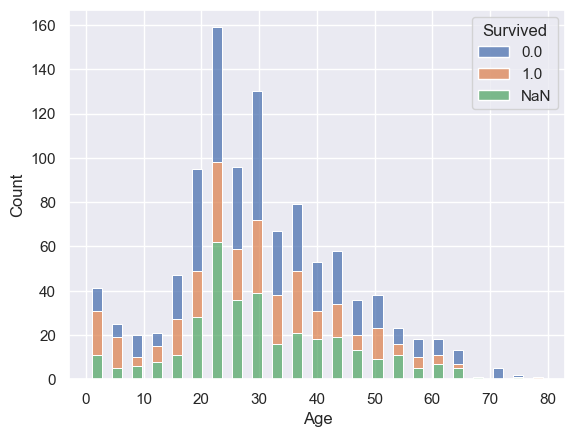

In [26]:
sns.histplot(data=df,
             x='Age',
             hue='Survived',
             multiple='stack',
             shrink=0.5)


We see that a lot of kids were saved. On the other hand, the old people have a high death rating.
Considering that a few people above 65, I'll change the age of these people to 65.


In [27]:
df.loc[df['Age'] >= 65, 'Age'] = 65


<h4> 1.4 Siblings and spouse (SibSp)</h4>


<AxesSubplot: xlabel='SibSp', ylabel='Count'>

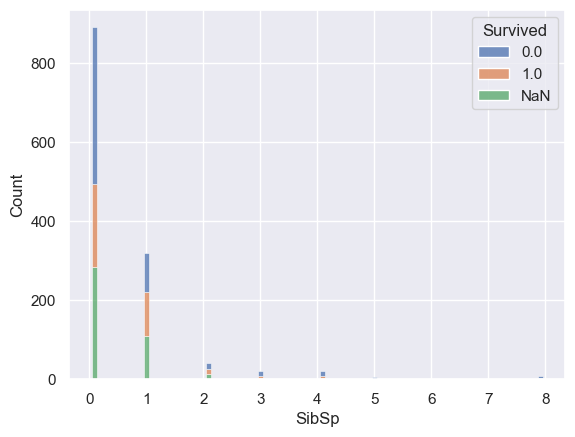

In [28]:
sns.histplot(data=df,
             x='SibSp',
             hue='Survived',
             multiple='stack',
             shrink=0.5)


<AxesSubplot: xlabel='SibSp', ylabel='Count'>

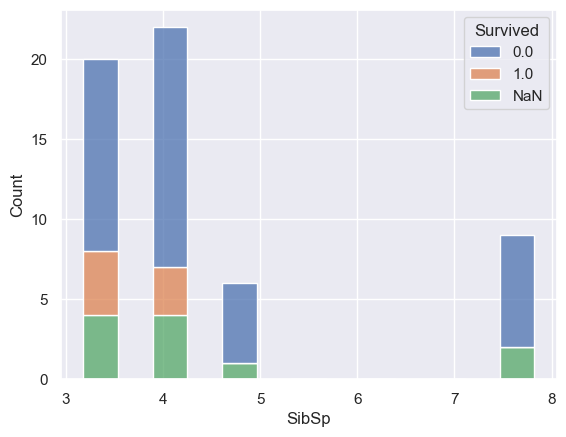

In [29]:
# Closer look at big families
sns.histplot(data=df.loc[df['SibSp'] > 2],
             x='SibSp',
             hue='Survived',
             multiple='stack',
             shrink=0.5)


Many people with several siblings did not survive... I'll combine all values in three categories:

<ul>
  <li>0: no siblings and no spouse</li>
  <li>1: 1-2 siblings or a spouse </li>
  <li>2: more than 2</li>
</ul>


In [30]:
df.loc[(df['SibSp'] == 0), 'SibSp'] = 0
df.loc[(df['SibSp'] > 0) & (df['SibSp'] < 3), 'SibSp'] = 1
df.loc[df['SibSp'] >= 3, 'SibSp'] = 2


<h4> 1.5 Parents and children (Parch)</h4>


<AxesSubplot: xlabel='Parch', ylabel='Count'>

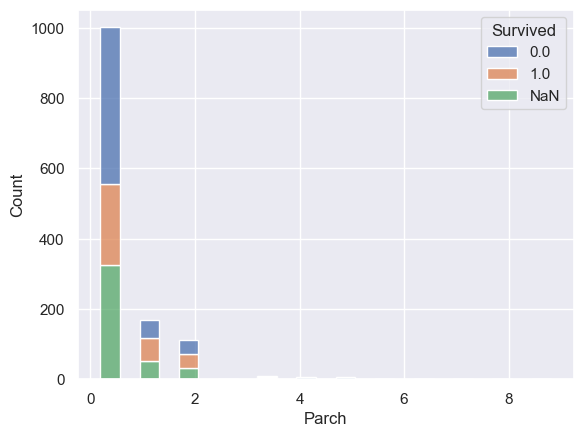

In [31]:
sns.histplot(data=df,
             x='Parch',
             hue='Survived',
             multiple='stack',
             shrink=0.5)


<AxesSubplot: xlabel='Parch', ylabel='Count'>

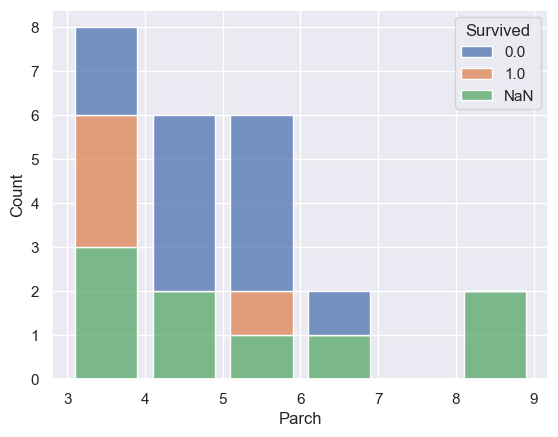

In [32]:
# Closer look at big families
sns.histplot(data=df.loc[df['Parch'] > 2],
             x='Parch',
             hue='Survived',
             multiple='stack',
             shrink=0.8)


Same story for passengers with many children. So, the same tactic.

<ul>
  <li>0: no children or parents</li>
  <li>1: 1-3 parents and children </li>
  <li>2: more than 3</li>
</ul>


In [33]:
df.loc[(df['Parch'] == 0), 'Parch'] = 0
df.loc[(df['Parch'] > 0) & (df['Parch'] <= 3), 'Parch'] = 1
df.loc[df['Parch'] >= 4, 'Parch'] = 2


<h4> 1.6 Embarked </h4>


<AxesSubplot: xlabel='Embarked', ylabel='Count'>

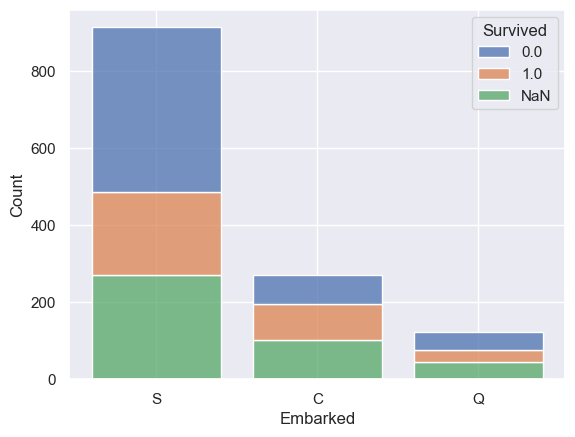

In [34]:
sns.histplot(data=df,
             x='Embarked',
             hue='Survived',
             multiple='stack',
             shrink=0.8)


<h4> 1.7 Cabin </h4>


Let's keep from all cavin values just the first letter to show a sector of the ship. All empyt values I fill as N/A


In [35]:
df['Cabin'] = df['Cabin'].fillna('N/A')
df['Section'] = df['Cabin'].apply(
    lambda x: str(x)[:1] if x != 'N/A' else 'N/A')


<AxesSubplot: xlabel='Section', ylabel='Count'>

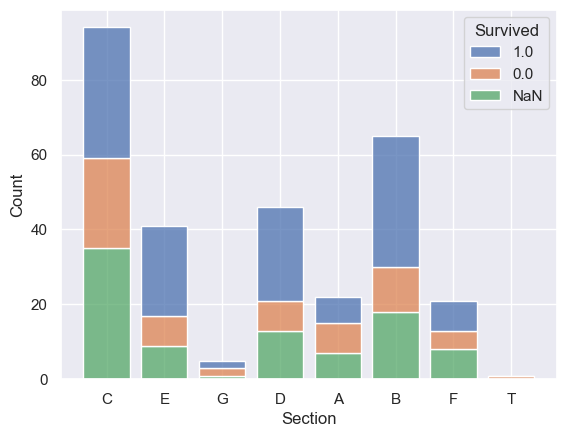

In [36]:
sns.histplot(data=df.loc[(df['Section'] != 'N/A')],
             x='Section',
             hue='Survived',
             multiple='stack',
             shrink=0.8)


We can see that the number of survived people are significant in some sections. This feature seems informative even with many empty values. However, I'll fill a row with a single T section with N/A because it doesn't exist in the test set.


In [37]:
df.loc[df['Section'] == 'T', 'Section'] = 'N/A'


<h4> 1.8 Names </h4>


In [38]:
df[["Surname", "Name"]] = [i.split(",") for i in df["Name"].values]


In [39]:
a = df.groupby("Surname")["Surname"].count()
fam_list = a[a > 1].index.values
df.loc[~df["Surname"].isin(fam_list), "Surname"] = "Other"


In [40]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
dfplt = dfplt[dfplt["Surname"] != "Other"]
fig = px.histogram(dfplt, x="Surname", color="Survived",
                   color_discrete_sequence=cm)
fig.show()


Let's add a column with information about namesakes.


In [41]:
df["Namesakes"] = 1
df.loc[df["Surname"] == "Other", "Namesakes"] = 0


I'm going to put the title of every person in the separate column and use it as as a kind of age category


In [42]:
df["Title"] = pd.DataFrame(df["Name"].str.strip().str.split(
    ".").tolist()).set_index(df.index).iloc[:, 0]
df["Title"] = df["Title"].fillna("Others")


In [43]:
fig = px.histogram(df, x="Title", color="Survived", color_discrete_sequence=cm)
fig.show()


In [44]:
# The only female doctor
df.loc[df['Name'] == 'Dr. Alice (Farnham)', 'Title'] = 'Mrs'


Let's categorize rare titles to Miss, Mrs, and Mr. Master title is used for male children.


In [45]:
rename = {"Miss": ["Ms", 'Mlle'],
          "Mrs": ["Mme", "Lady", "the Countess", "Dona"],
          "Mr": ['Capt', "Dr", "Sir", 'Col', 'Major', 'Don', 'Rev', 'Captain', "Jonkheer"]
          }
for k in rename:
    df["Title"] = df["Title"].replace(rename[k], k)


In [46]:
fig = px.histogram(df, x="Title", color="Survived", color_discrete_sequence=cm)
fig.show()


<h4> 1.10 Ticket </h4>


I'm going to take a letter code from every possible ticket and put it in the separate column


In [47]:
def lin_rep(x): return x.replace({'LINE': "370160"})


df = lin_rep(df)


In [48]:
prefixes = []
nums, prefs = [], []
for i in df["Ticket"].values:
    if not i.isdigit():
        nums.append(int(re.search('.* {1}([0-9]+)', i).groups()[0]))
        prefix = re.search('(.*)( {1})[0-9]+', i).groups()[0]
        # Needed to put in one group such prefixes as "A/5", "A/5.", "A.5" etc.
        prefs.append(prefix.replace(".", "").replace(" ", "").replace("/", ""))
    else:
        nums.append(int(i))
        prefs.append("")
df["Ticket"] = nums
df["Ticket_p"] = prefs


In [49]:
dfplt = df.copy(deep=True)
fig = px.scatter(dfplt.astype(str), x="Ticket_p", y="Name", color="Survived",
                 color_discrete_sequence=cm, size_max=6, width=1200, height=500)
fig.show()


In [50]:
drop = ["SP", "SOP", "Fa", "SCOW", "PPP", "AS", "CASOTON", "SWPP",
        "SCAHBasle", "SCA3", "STONOQ", "AQ4", "A2", "LP", "AQ3", ""]
df = df.replace(drop, 'N/A')


<h1> 2. Preprocessing </h1>


In [51]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   object 
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   int64  
 9   Fare         1308 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1307 non-null   object 
 12  Section      1309 non-null   object 
 13  Surname      1309 non-null   object 
 14  Namesakes    1309 non-null   int64  
 15  Title        1309 non-null   object 
 16  Ticket_p     1309 non-null   object 
dtypes: float64(2), int64(6), object(9)
memory usage: 174.0+ KB


<h4> 2.1 Embarked </h4>


Due to a categorical type, I fill with the most frequent value


In [52]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df[['Embarked']] = imp_mean.fit_transform(df[['Embarked']])


<h4> 2.2 One Hot Encoder </h4>


In [53]:
def use_ohe(df, features):
    df_local = pd.DataFrame()
    for feature in features:
        ohe = preprocessing.OneHotEncoder()
        transformed = ohe.fit_transform(df[[feature]])
        df_local[ohe.get_feature_names_out()] = transformed.toarray()
    return df_local


In [54]:
df.columns


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Section', 'Surname',
       'Namesakes', 'Title', 'Ticket_p'],
      dtype='object')

Obvious categorical values are Embarked, Title, Section, and Ticket_p.
Pclass, SibSp, and Parch are kept as a continuous variables because the higher or lower value causes the difference in surviving rate


In [55]:
for_ohe = ['Embarked', 'Title', 'Section', 'Ticket_p']


df_final = pd.concat([df['Sex'].apply(lambda x: int(x == 'male')).copy(),
                      df[['Age', 'Pclass', 'SibSp', 'Parch', 'Namesakes']].copy(),
                      use_ohe(df, for_ohe)],
                     axis=1)


<h4> 2.3 Filling NaN values in the Age column </h4>


There are many empty values in the Age column, so I need to find a complex way to deal with them instead of just imputing mean or meadian of all values.
I'm going to predict them.


In [56]:
age_features = np.delete(df_final.columns.to_numpy(), 1)

age_x_train = df_final[~df_final['Age'].isna()].drop('Age', axis=1)[
    age_features]
age_y_train = df_final[~df_final['Age'].isna()]['Age']
age_x_test = df_final[df_final['Age'].isna()].drop('Age', axis=1)[age_features]
age_y_test = df_final[df_final['Age'].isna()]['Age']

model = LinearRegression()
model.fit(age_x_train, age_y_train)

age_predict = model.predict(age_x_test)
df_final.loc[df_final['Age'].isnull(), 'Age'] = age_predict


In [57]:
fig = px.histogram(df_final, x="Age",
                   color=df["Survived"], color_discrete_sequence=cm)
fig.show()


Look closer to kids and elder people


In [58]:
kid_index = df_final[df_final['Age'] < 18].index
fig = px.histogram(df_final.loc[kid_index], x="Age",
                   color=df.loc[kid_index]["Survived"], color_discrete_sequence=cm)
fig.show()


In [59]:
old_index = df_final[df_final['Age'] > 60].index
fig = px.histogram(df_final.loc[old_index], x="Age",
                   color=df.loc[old_index]["Survived"], color_discrete_sequence=cm)
fig.show()


In [60]:
df_final['Kid'] = df_final['Age'].apply(lambda x: 1 if x < 8 else 0)
df_final['Old'] = df_final['Age'].apply(lambda x: 1 if x > 60 else 0)


<h1> 3. Model development </h1>


In [75]:
df_final.columns


Index(['Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Namesakes', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Section_A', 'Section_B', 'Section_C', 'Section_D',
       'Section_E', 'Section_F', 'Section_G', 'Section_N/A', 'Ticket_p_A4',
       'Ticket_p_A5', 'Ticket_p_C', 'Ticket_p_CA', 'Ticket_p_FC',
       'Ticket_p_FCC', 'Ticket_p_N/A', 'Ticket_p_PC', 'Ticket_p_PP',
       'Ticket_p_SC', 'Ticket_p_SCA4', 'Ticket_p_SCAH', 'Ticket_p_SCPARIS',
       'Ticket_p_SCParis', 'Ticket_p_SOC', 'Ticket_p_SOPP', 'Ticket_p_SOTONO2',
       'Ticket_p_SOTONOQ', 'Ticket_p_STONO2', 'Ticket_p_WC', 'Ticket_p_WEP',
       'Kid', 'Old'],
      dtype='object')

In [61]:
x = df_final.loc[train_index]

rng = 42

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=rng)


In [62]:
cv = ShuffleSplit(n_splits=5, random_state=rng)


In [63]:
df_accuracy = pd.DataFrame(columns=['accuracy', 'model'])


In [64]:
# CatBoost classifier

model_c = CatBoostClassifier(verbose=False)
grid = {"l2_leaf_reg": [3, 4, 5, 6, 7, 8, 9, 10],
        "random_strength": [1, 0.9],
        "learning_rate": [0.00855],
        "depth": [6]}
clf = GridSearchCV(model_c, grid, cv=cv)

clf.fit(x_train, y_train)
model_c = clf.best_estimator_
y_predict = model_c.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_predict) * 100}")
df_y_accuracy = pd.DataFrame([[accuracy_score(y_test, y_predict), model_c]],
                             columns=['accuracy', 'model'], index=['cat'])
df_accuracy = pd.concat([df_accuracy, df_y_accuracy])
df_accuracy['model']['cat']


Accuracy: 83.2089552238806


In [65]:
scaler = StandardScaler()
model_s = SVC()
pipe = Pipeline(steps=[("scaler", scaler), ("svc", model_s)])

grid = {"svc__kernel": ['poly', 'rbf', 'linear'],
        "svc__C": [.1, 1, 2, 3]}
clf = GridSearchCV(pipe, grid, cv=cv)
clf.fit(x_train, y_train)
model_s = clf.best_estimator_

y_predict = model_s.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_predict) * 100}")
df_y_accuracy = pd.DataFrame([[accuracy_score(y_test, y_predict), model_s]],
                             columns=['accuracy', 'model'], index=['svc'])
df_accuracy = pd.concat([df_accuracy, df_y_accuracy])
df_accuracy['model']['svc']


Accuracy: 80.97014925373134


Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(C=1, kernel='linear'))])

In [66]:
model_l = LogisticRegression(max_iter=9000, penalty='elasticnet')
grid = {"l1_ratio": [0, .05, .1, 1],
        'solver': ['saga', 'liblinear']}
clf = GridSearchCV(model_l, grid, cv=cv)
clf.fit(x_train, y_train)
model_l = clf.best_estimator_

y_predict = model_l.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_predict) * 100}")
df_y_accuracy = pd.DataFrame([[accuracy_score(y_test, y_predict), model_l]],
                             columns=['accuracy', 'model'], index=['log'])
df_accuracy = pd.concat([df_accuracy, df_y_accuracy])
df_accuracy['model']['log']


Accuracy: 83.5820895522388


LogisticRegression(l1_ratio=0, max_iter=9000, penalty='elasticnet',
                   solver='saga')

In [67]:
grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [i for i in np.arange(3, 10)],
    'learning_rate': [rate for rate in np.arange(0.1, 1.5, 0.2)]
}
model_x = XGBClassifier()
clf = GridSearchCV(model_x, grid, cv=cv)
clf.fit(x_train, y_train)
model_x = clf.best_estimator_
y_predict = model_x.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_predict) * 100}")
df_y_accuracy = pd.DataFrame([[accuracy_score(y_test, y_predict), model_x]],
                             columns=['accuracy', 'model'], index=['xgb'])
df_accuracy = pd.concat([df_accuracy, df_y_accuracy])
df_accuracy['model']['xgb']


Accuracy: 82.83582089552239


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [68]:
grid = {"n_estimators": [50, 100, 150, 200, 300, 400, 500]}
model_r = RandomForestClassifier()
clf = GridSearchCV(model_r, grid, cv=cv)
clf.fit(x_train, y_train)
model_r = clf.best_estimator_
y_predict = model_r.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_predict) * 100}")
df_y_accuracy = pd.DataFrame([[accuracy_score(y_test, y_predict), model_r]],
                             columns=['accuracy', 'model'], index=['rf'])
df_accuracy = pd.concat([df_accuracy, df_y_accuracy])
df_accuracy['model']['rf']


Accuracy: 81.34328358208955


RandomForestClassifier(n_estimators=150)

In [69]:
scaler = StandardScaler()
model_k = KNeighborsClassifier()
pipe = Pipeline(steps=[("scaler", scaler), ("KN", model_k)])

grid = {"KN__weights": ['uniform', 'distance'],
        "KN__n_neighbors": [n for n in np.arange(5, 20, 2)],
        'KN__p': [1, 2]}


clf = GridSearchCV(pipe, grid, cv=cv)
clf.fit(x_train, y_train)

model_k = clf.best_estimator_
y_predict = model_k.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_predict) * 100}")
df_y_accuracy = pd.DataFrame([[accuracy_score(y_test, y_predict), model_k]],
                             columns=['accuracy', 'model'], index=['kn'])
df_accuracy = pd.concat([df_accuracy, df_y_accuracy])
df_accuracy['model']['kn']


Accuracy: 81.34328358208955


Pipeline(steps=[('scaler', StandardScaler()),
                ('KN', KNeighborsClassifier(n_neighbors=15, p=1))])

In [70]:


model_a = AdaBoostClassifier()
grid = {"n_estimators": [50, 100, 150, 200, 300, 400, 500],
        "learning_rate": [rate for rate in np.arange(0.1, 1.5, 0.2)]}
clf = GridSearchCV(model_a, grid, cv=cv)
clf.fit(x_train, y_train)
model_a = clf.best_estimator_
y_predict = model_a.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_predict) * 100}")

df_y_accuracy = pd.DataFrame([[accuracy_score(y_test, y_predict), model_a]],
                             columns=['accuracy', 'model'], index=['ada'])
df_accuracy = pd.concat([df_accuracy, df_y_accuracy])
df_accuracy['model']['ada']


Accuracy: 84.32835820895522


AdaBoostClassifier(learning_rate=0.30000000000000004)

In [71]:
model_g = GradientBoostingClassifier(n_estimators=100)
grid = {"n_estimators": [50, 100, 150, 200, 300, 400, 500],
        "learning_rate": [rate for rate in np.arange(0.1, 1.5, 0.2)]}
clf = GridSearchCV(model_g, grid, cv=cv)
clf.fit(x_train, y_train)
model_g = clf.best_estimator_
y_predict = model_g.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_predict) * 100}")

df_y_accuracy = pd.DataFrame([[accuracy_score(y_test, y_predict), model_g]],
                             columns=['accuracy', 'model'], index=['grad'])
df_accuracy = pd.concat([df_accuracy, df_y_accuracy])
df_accuracy['model']['grad']


Accuracy: 84.70149253731343


GradientBoostingClassifier()

In [72]:
df_top = df_accuracy.sort_values(['accuracy'], ascending=False)

best_model = df_top.iloc[0, 1]
best_model


GradientBoostingClassifier()

In [73]:
best_model.fit(x_train, y_train)
y_predict = best_model.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_predict) * 100}")


Accuracy: 84.70149253731343


In [74]:
pred = best_model.predict(df_final.loc[test_index])

pd.DataFrame({
    'PassengerId': df.loc[test_index]['PassengerId'],
    'Survived': pred
}).to_csv('submission.csv', index=False)
